In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tools
import warnings,sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")


In [2]:
# Load data
load_file = '../datasets/reddit_submissions.json'
someposts = pd.read_json(load_file , lines=True)
someposts.index = someposts['id']


# Model
Possible models:
+ Bag of Words/Bigrams + LR/SVM
+ Average Embedding + LR
+ LDA
+ Tree Kernels
+ @RNN: I try word-based 1-layer LSTM as baseline 
+ @CNN: I secondly try character-level CNN
+ @RCNN: I finally will try the advanced RCNN

I first try the simplest word-based LSTM, then try character-level CNN and finally try advanced word-based RCNN if possible. 

In [8]:
from tensorflow import keras
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers import Reshape, Conv1D, GlobalMaxPooling1D, MaxPooling1D,Flatten

from sklearn.metrics import classification_report

## 1: word-based one-layer LSTM  
LSTM could capture the contextual feature of text. Shown in Part1_ModelTraining with avg f1-score is 0.62. This model is good to classify 3-'EatingDisorders' with 0.80 and 7-'alcoholism' with 0.81.

## 2: charactor-based one-layer CNN 
The character-level cnn is effective and unbiased, but we have to define fixed size kernel while words with different length.

In [4]:
maxlen = 2000
vocabulary_size = 40

# Preprocesses the raw data as required
subreddit_mappings, someposts = tools.record_process(someposts, features = ['title', 'selftext'])

# Fit the tokenizer on the training data
t = Tokenizer(num_words=vocabulary_size, char_level=True)
t.fit_on_texts(someposts[['title','selftext']].apply(lambda x: 'End. '.join(x), axis=1).values)
print('%s unique words' %len(t.word_index))

# partitions the model-ready data into train, validation, and test sets.
X_train = t.texts_to_sequences(someposts[['title','selftext']].apply(lambda x: 'End. '.join(x), axis=1).values)
X_train = pad_sequences(X_train, maxlen=maxlen, padding='post')
X_train, X_val, y_train, y_val = train_test_split(X_train,someposts['target'].values, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val,y_val, test_size=0.5)
print('There are {},{},{} records for train, validation, and test sets'.format(len(X_train), len(X_val), len(X_test)))

There are 236742 records after processing
The sum of rare categories is 1142
591 unique words
There are 189393,23674,23675 records for train, validation, and test sets


In [12]:
# training
n_classes = len(subreddit_mappings)

model = Sequential()
model.add(Reshape((maxlen, 1), input_shape=(maxlen,)))
model.add(Conv1D(150, 15, activation='relu'))
model.add(MaxPooling1D(pool_size=10, strides=5))
model.add(Conv1D(300, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(n_classes, activation='softmax'))
model.summary()

# complie
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 2000, 1)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1986, 150)         2400      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 396, 150)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 392, 300)          225300    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 17)                5117      
Total params: 232,817
Trainable params: 232,817
Non-trainable params: 0
_________________________________________________________________


Train on 189393 samples, validate on 23674 samples
Epoch 1/5
189393/189393 [==============================] - 31777s 168ms/step - loss: 1.9517 - acc: 0.3939 - val_loss: 1.8387 - val_acc: 0.4197
Epoch 2/5
189393/189393 [==============================] - 3197s 17ms/step - loss: 1.7310 - acc: 0.4452 - val_loss: 1.7008 - val_acc: 0.4614
Epoch 3/5
189393/189393 [==============================] - 4799s 25ms/step - loss: 1.6196 - acc: 0.4803 - val_loss: 1.6238 - val_acc: 0.4831
Epoch 4/5
189393/189393 [==============================] - 3098s 16ms/step - loss: 1.5552 - acc: 0.4984 - val_loss: 1.6010 - val_acc: 0.4903
Epoch 5/5
189393/189393 [==============================] - 3012s 16ms/step - loss: 1.5152 - acc: 0.5102 - val_loss: 1.5497 - val_acc: 0.4997


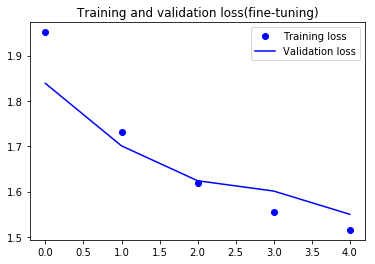

In [13]:
# prepare for training
early_stopping = keras.callbacks.EarlyStopping(monitor='acc', 
                                                  min_delta=0.0001,
                                                  patience=1, 
                                                  verbose=1)

checkpoint = keras.callbacks.ModelCheckpoint('ModelTraining/lstm_1st.hdf5', 
                                             verbose=1, 
                                             save_best_only=True) 
# training
history = model.fit(X_train, y_train, 
                    batch_size = 64,
                    epochs=5, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# plot the training process
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss(fine-tuning)')
plt.legend()

plt.show()

In [ ]:
# Evaluation
results = model.predict(X_test)
predictions = results.argmax(axis = 1)
print(classification_report(y_test, predictions))

# save
#Save partly trained model
model.save('ModelTraining/partly_trained_cnn_0613.h5')

## 3: recurrent convolutional neural network
According to paper, RecurrentNN is a biased model, where later words are more dominant than earlier words. The Convolutional Neural Network (CNN) is unbiased to NLP tasks, which can fairly determine discriminative phrases in a text with a max-pooling layer, but it is difficult to determine the window size. Hence, RCNN for text classification that learn more contextual information than conventional window-based neural networks and represent the semantic of texts more precisely for text classification.

'First, we apply a bi-directional recurrent structure. Second, we employ a max-pooling layer that automatically judges which features play key roles in text classification, to capture the key component in the texts. '

For the '2015-fancy' model-RCNN. Under time limitation, I plan to use other codes as reference and fit it to our model.
+ The paper: Recurrent Convolutional Neural Network for Text Classification (AAAI 2015) https://www.aaai.org/ocs/index.php/AAAI/AAAI15/paper/view/9745
+ The reference code: 
https://github.com/roomylee/rcnn-text-classification; 
https://github.com/sklan/rcnn-text-classification